In [ ]:
import pandas as pd

data = pd.read_csv('/content/cardio_train.csv', sep=';')
data.rename(columns={'cardio': 'target'}, inplace=True)

print("✅ Dataset loaded successfully and 'cardio' column renamed to 'target'.")
print("Initial Dataset Preview:")
print(data.head())

✅ Dataset loaded successfully and 'cardio' column renamed to 'target'.
Initial Dataset Preview:
   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  target  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


In [ ]:
# ------------------------------------------------------------
# EDA Step 1: Initial Data Preparation for EDA
# ------------------------------------------------------------

# Convert age from days to years for better interpretability
data['age_years'] = (data['age'] / 365.25).astype(int)

# Drop the 'id' column as it's just an identifier and not useful for modeling
# Also drop the original 'age' column as we've created 'age_years'
data = data.drop(columns=['id', 'age'], errors='ignore')

print("✅ 'id' column dropped and 'age' converted to 'age_years'.")
print("Updated Dataset Preview:")
print(data.head())

✅ 'id' column dropped and 'age' converted to 'age_years'.
Updated Dataset Preview:
   gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0       2     168    62.0    110     80            1     1      0     0   
1       1     156    85.0    140     90            3     1      0     0   
2       1     165    64.0    130     70            3     1      0     0   
3       2     169    82.0    150    100            1     1      0     0   
4       1     156    56.0    100     60            1     1      0     0   

   active  target  age_years  
0       1       0         50  
1       1       1         55  
2       0       1         51  
3       1       1         48  
4       0       0         47  


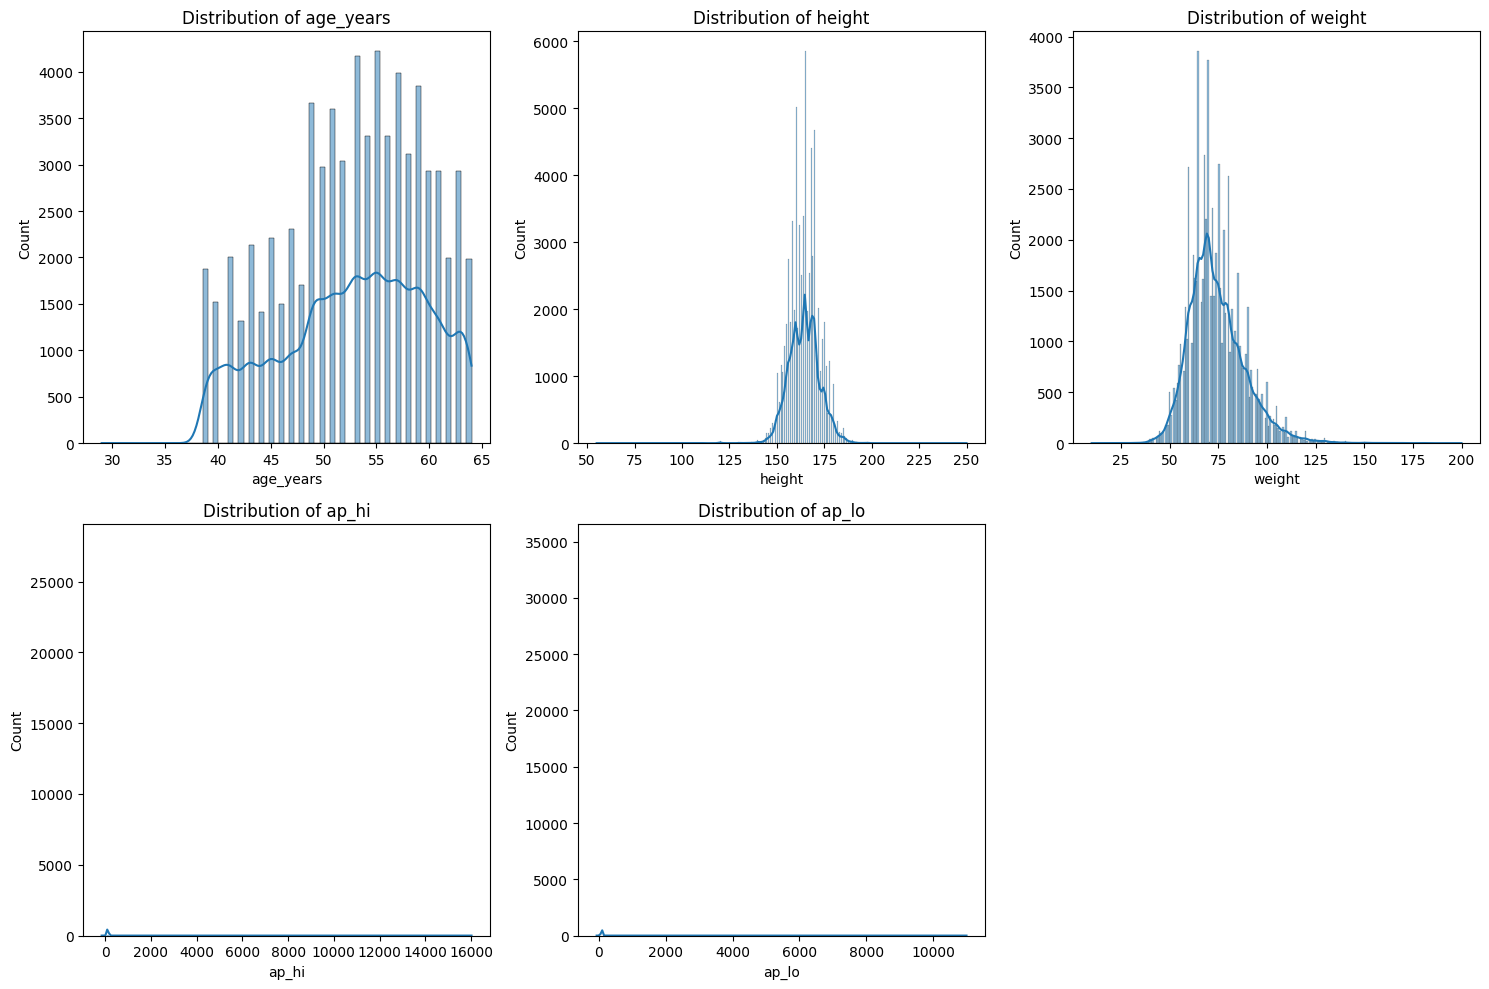

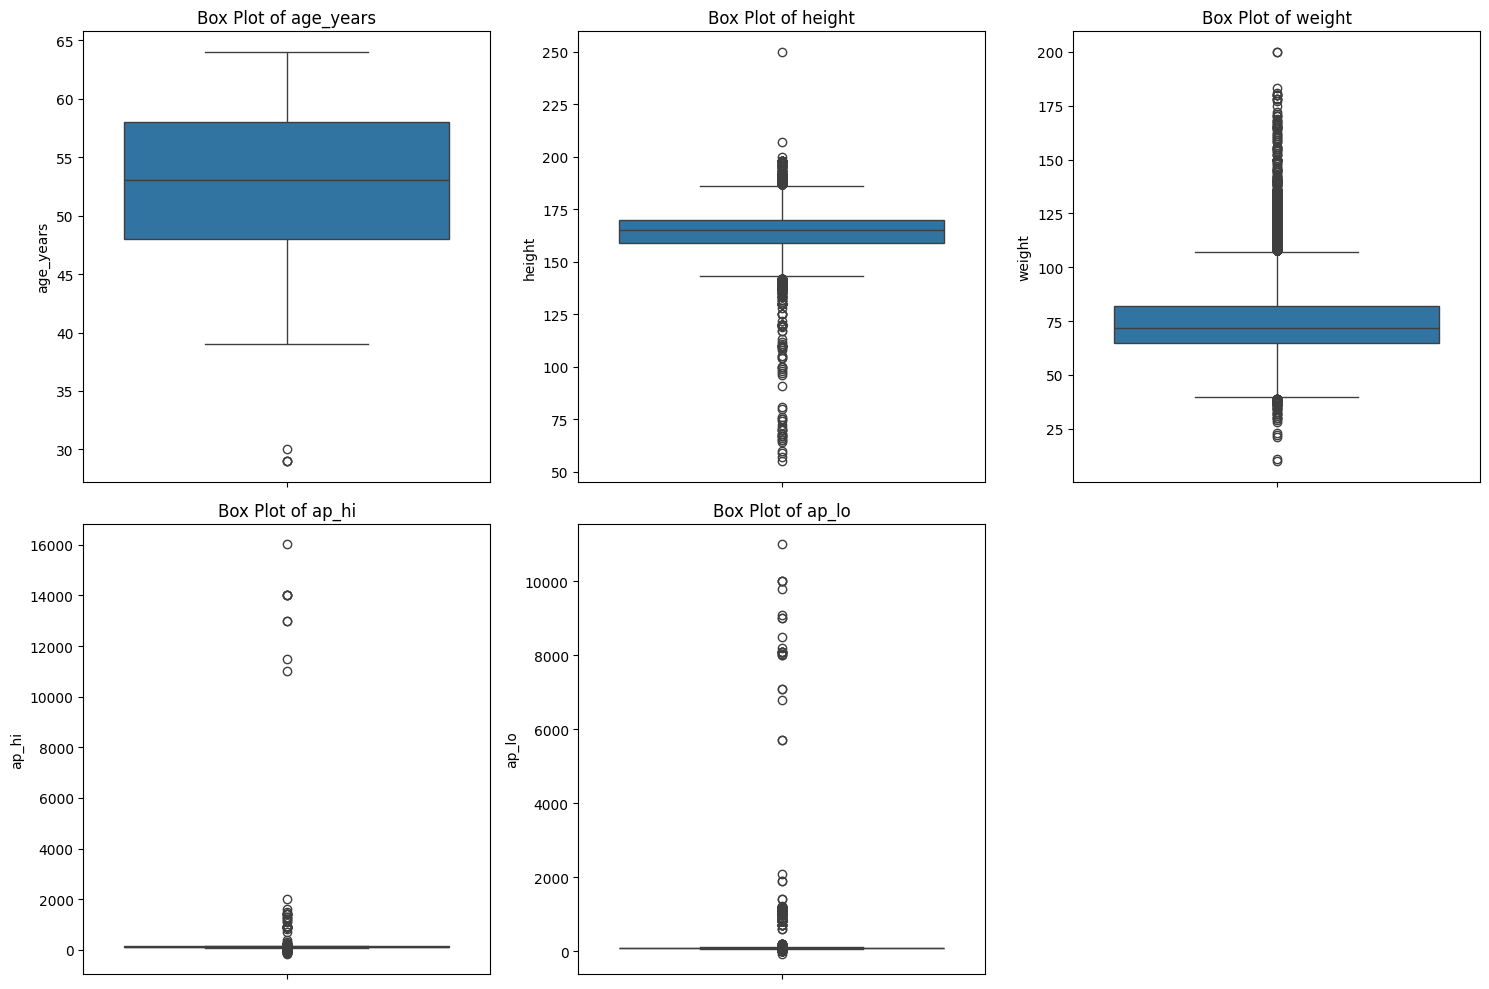

✅ Univariate analysis for numerical features complete (histograms and box plots).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# EDA Step 2: Univariate Analysis of Numerical Features
# ------------------------------------------------------------

numerical_cols = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

print("✅ Univariate analysis for numerical features complete (histograms and box plots).")

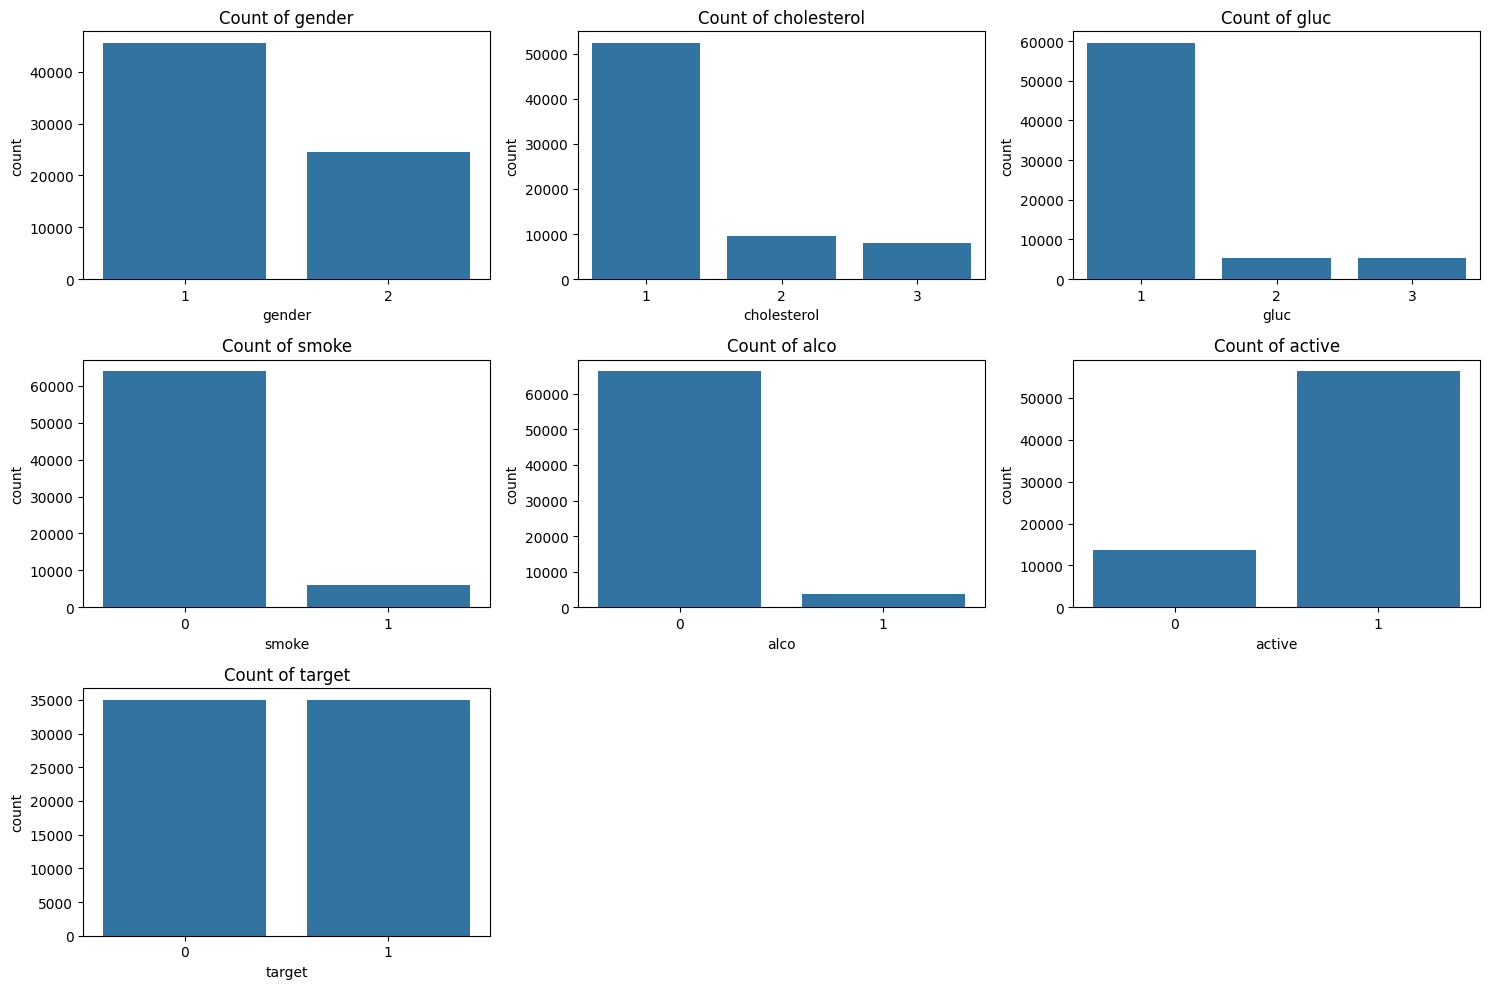

✅ Univariate analysis for categorical features complete (count plots).


In [ ]:
# ------------------------------------------------------------
# EDA Step 3: Univariate Analysis of Categorical Features
# ------------------------------------------------------------

categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'target']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=data[col])
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()

print("✅ Univariate analysis for categorical features complete (count plots).")

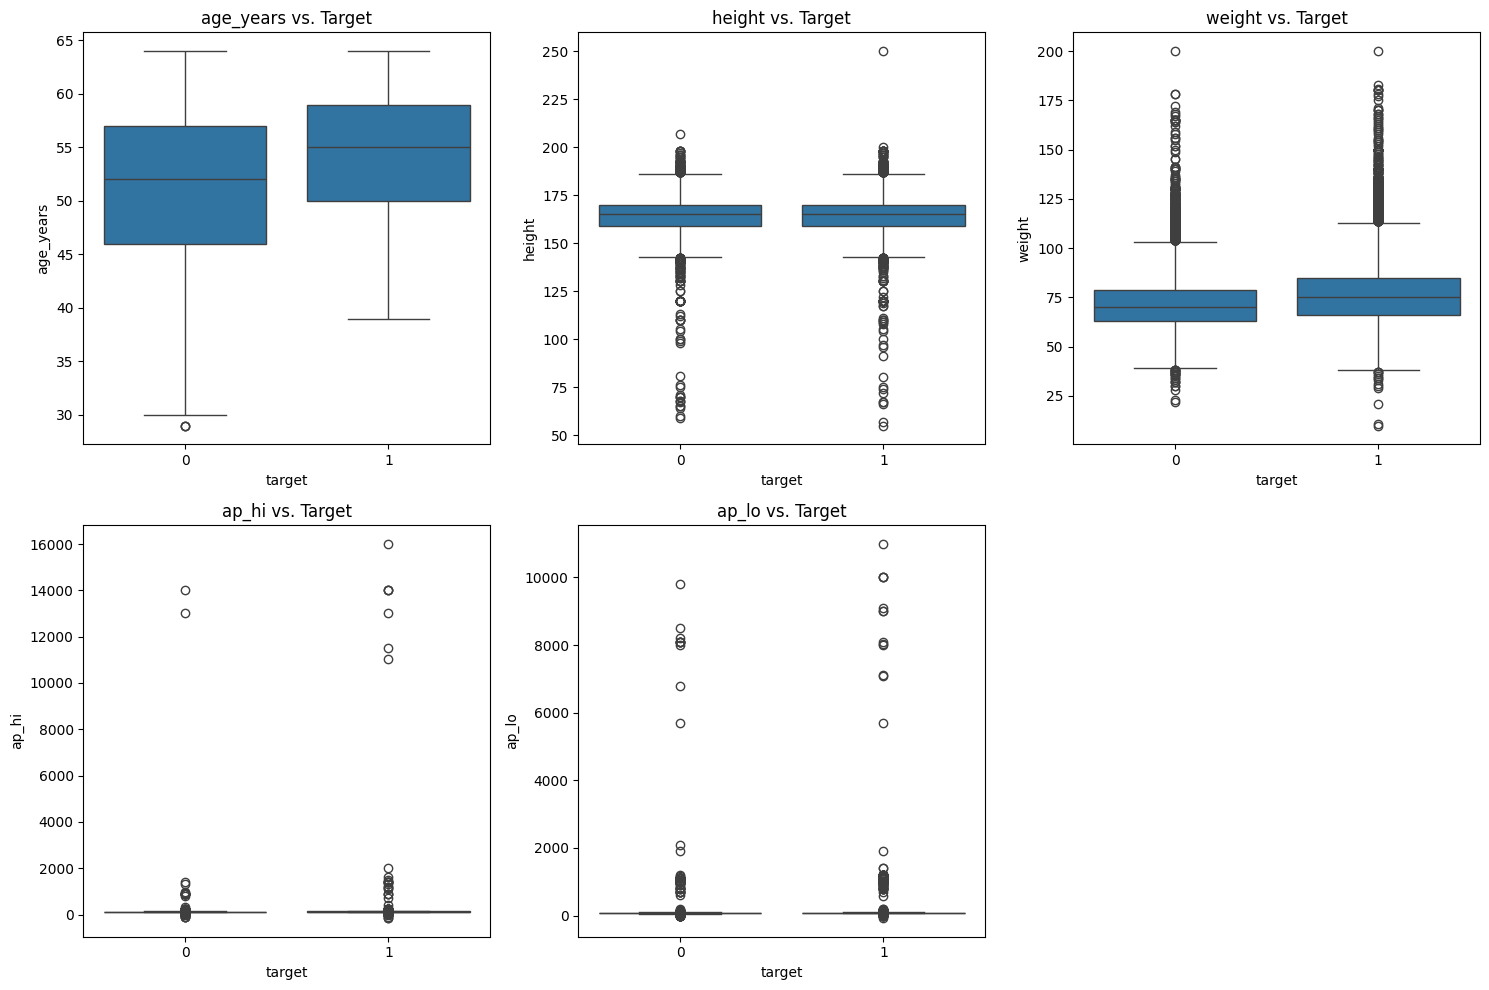

✅ Bivariate analysis for numerical features vs. target complete.


In [ ]:
# ------------------------------------------------------------
# EDA Step 4: Bivariate Analysis - Numerical Features vs. Target
# ------------------------------------------------------------

numerical_cols_for_target = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_for_target):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='target', y=col, data=data)
    plt.title(f'{col} vs. Target')
plt.tight_layout()
plt.show()

print("✅ Bivariate analysis for numerical features vs. target complete.")

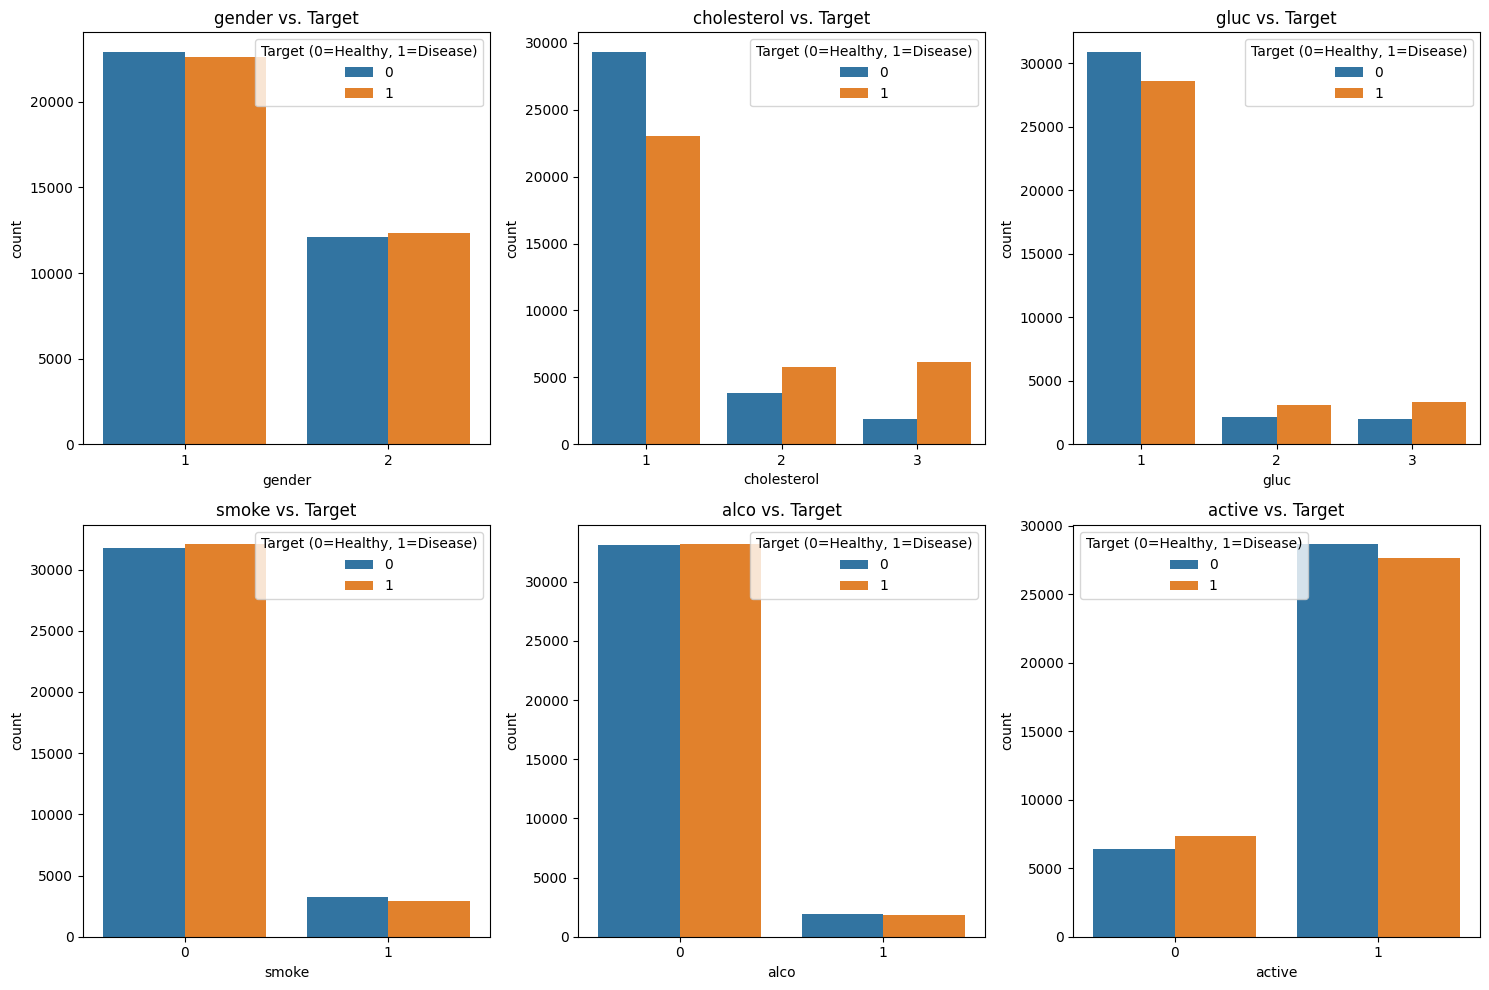

✅ Bivariate analysis for categorical features vs. target complete.


In [ ]:
# ------------------------------------------------------------
# EDA Step 5: Bivariate Analysis - Categorical Features vs. Target
# ------------------------------------------------------------

categorical_cols_for_target = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols_for_target):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='target', data=data)
    plt.title(f'{col} vs. Target')
    plt.legend(title='Target (0=Healthy, 1=Disease)')
plt.tight_layout()
plt.show()

print("✅ Bivariate analysis for categorical features vs. target complete.")

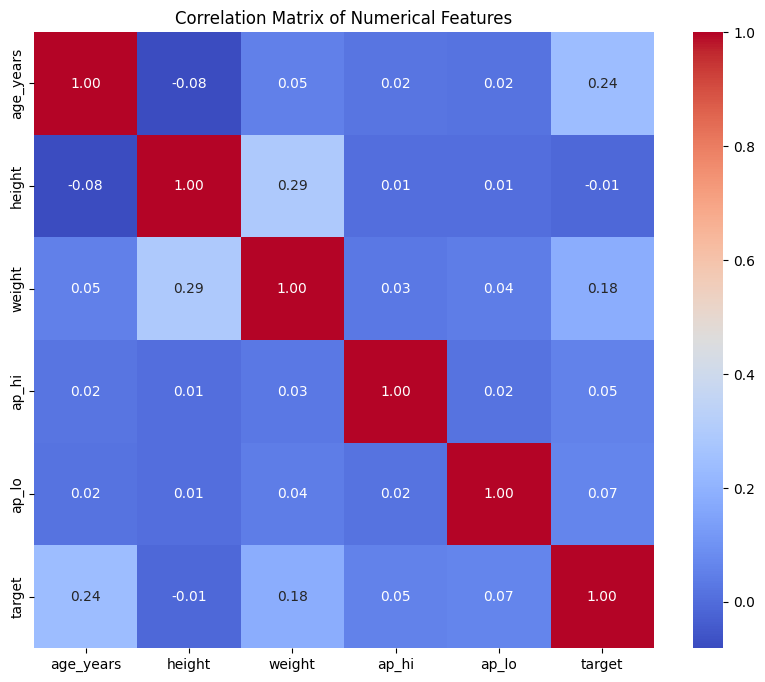

✅ Correlation matrix generated.


In [ ]:
# ------------------------------------------------------------
# EDA Step 6: Correlation Matrix
# ------------------------------------------------------------

# Select only numerical columns for correlation matrix
numerical_data = data[numerical_cols + ['target']]
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

print("✅ Correlation matrix generated.")

In [ ]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

RANDOM_STATE = 42
DATA_PATH = "/content/cardio_train.csv"
MODEL_SAVE = "/content/heart_disease_model.pkl"
SCALER_SAVE = "/content/scaler.pkl"

# -------------------------
# 1) Load & preprocess
# -------------------------
df = pd.read_csv(DATA_PATH, sep=';')
if 'cardio' in df.columns:
    df.rename(columns={'cardio':'target'}, inplace=True)
df.drop(columns=['id'], errors='ignore', inplace=True)
if 'age' in df.columns:
    df['age_years'] = (df['age'] / 365.25).round(1)
    df.drop(columns=['age'], inplace=True)

# Feature Engineering
df['bmi'] = df['weight'] / ((df['height'] / 100)**2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['mean_arterial_pressure'] = df['ap_lo'] + (1/3) * (df['ap_hi'] - df['ap_lo'])

# Outlier Handling (capping)
# Based on common physiological ranges and typical dataset distributions
# ap_hi: Systolic blood pressure. Normal is <120. Hypertension can be up to 180+. Outliers usually much higher.
df['ap_hi'] = np.clip(df['ap_hi'], 70, 240) # Capping lower at 70 (hypotension) and upper at 240 (severe hypertension)
# ap_lo: Diastolic blood pressure. Normal is <80. Hypertension can be up to 120+. Outliers usually much higher.
df['ap_lo'] = np.clip(df['ap_lo'], 40, 140) # Capping lower at 40 and upper at 140
# height: Capping to realistic human heights
df['height'] = np.clip(df['height'], 120, 200) # Capping between 120cm and 200cm
# weight: Capping to realistic human weights
df['weight'] = np.clip(df['weight'], 40, 160) # Capping between 40kg and 160kg

X = df.drop(columns=['target'])
y = df['target'].astype(int)

# drop non-numeric if any
non_num = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_num:
    print("Dropping non-numeric columns:", non_num)
    X = X.drop(columns=non_num)

# Ensure X columns are in the consistent order expected by the scaler and model
# Updated expected_training_features_order to include new features
expected_training_features_order = ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pulse_pressure', 'mean_arterial_pressure']
X = X[expected_training_features_order]

# scale with StandardScaler (works well for many pipelines)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Now scaler will be fitted on the updated 11 features

# train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# save scaler
joblib.dump(scaler, SCALER_SAVE)
print("Saved scaler to", SCALER_SAVE)

# -------------------------
# 2) Randomized search space
# -------------------------
param_dist = {
    "n_estimators": [400, 500, 600, 700, 800],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.07],
    "max_depth": [3, 4, 5, 6],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
    "gamma": [0, 0.05, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.01, 0.05, 0.1],
    "reg_lambda": [1, 1.5, 2, 3],
    "scale_pos_weight": [1, 1.0, 1.2, 1.3]  # tweak for imbalance
}

base_xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",     # faster on CPU
    use_label_encoder=False,
    random_state=RANDOM_STATE
)

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    estimator=base_xgb,
    param_distributions=param_dist,
    n_iter=25,            # adjust up/down for more search time
    scoring="roc_auc",
    cv=skf,
    verbose=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=False
)

# -------------------------
# 3) Run RandomizedSearchCV (may take several minutes)
# -------------------------
print("Starting RandomizedSearchCV ...")
rs.fit(X_train, y_train)
print("Done. Best CV ROC-AUC:", rs.best_score_)
print("Best params:", rs.best_params_)

# -------------------------
# 4) Train final classifier using best params (no early_stopping in .fit to avoid compatibility errors)
# -------------------------
best_params = rs.best_params_.copy()
# Ensure eval_metric and random_state set
best_params.update({"eval_metric":"logloss", "use_label_encoder":False, "random_state":RANDOM_STATE, "tree_method":"hist"})

final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)   # simple fit — stable across xgboost versions

# -------------------------
# 5) Evaluate on test set
# -------------------------
y_pred = final_model.predict(X_test)
try:
    y_prob = final_model.predict_proba(X_test)[:,1]
except Exception:
    # fallback to decision_function if needed
    try:
        scores = final_model.decision_function(X_test)
        y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    except Exception:
        y_prob = y_pred.astype(float)

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print("\nFinal model performance on test set:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC : {roc:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))

# -------------------------
# 6) Save final model
# -------------------------
joblib.dump(final_model, MODEL_SAVE)
print("\nSaved final model to", MODEL_SAVE)


Saved scaler to /content/scaler.pkl
Starting RandomizedSearchCV ...
Fitting 4 folds for each of 25 candidates, totalling 100 fits
Done. Best CV ROC-AUC: 0.8041570113839782
Best params: {'subsample': 0.7, 'scale_pos_weight': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.05, 'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.7}

Final model performance on test set:
Accuracy: 0.7350
ROC-AUC : 0.8009

Classification report:
              precision    recall  f1-score   support

           0     0.7181    0.7743    0.7451      7004
           1     0.7548    0.6957    0.7240      6996

    accuracy                         0.7350     14000
   macro avg     0.7364    0.7350    0.7346     14000
weighted avg     0.7364    0.7350    0.7346     14000


Confusion matrix:
[[5423 1581]
 [2129 4867]]

Saved final model to /content/heart_disease_model.pkl


Loading dataset...
Loading model and scaler...

📈 Model Performance Summary (on Test Set):
----------------------------------------------------
✅ Accuracy:           0.7350
✅ Precision (macro):  0.7364
✅ Recall (macro):     0.7350
✅ F1-score (macro):   0.7346
✅ ROC-AUC Score:      0.8009
✅ PR-AUC (AP):        0.7850
----------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

           0     0.7181    0.7743    0.7451      7004
           1     0.7548    0.6957    0.7240      6996

    accuracy                         0.7350     14000
   macro avg     0.7364    0.7350    0.7346     14000
weighted avg     0.7364    0.7350    0.7346     14000



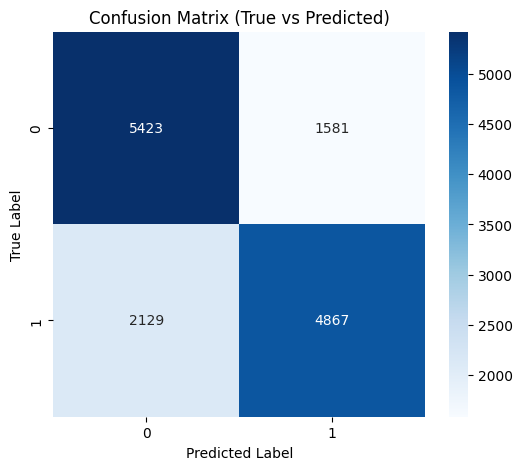

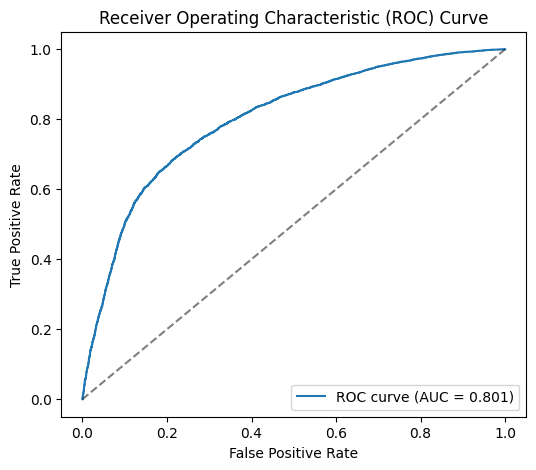

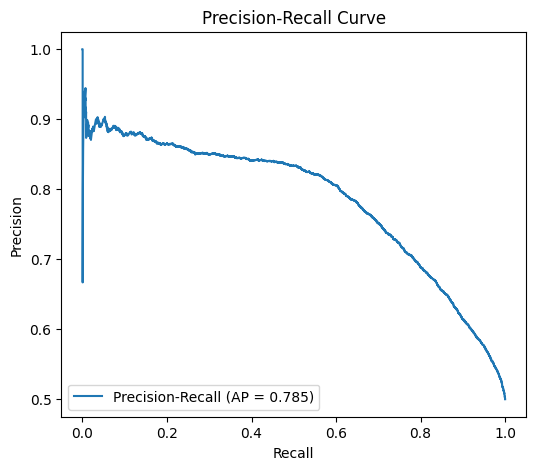


Saved summary metrics to '/content/xgboost_metrics_report.csv' and per-class report to '/content/xgboost_classification_report_per_class.csv'

Done.


In [ ]:
# ============================
# 📊 XGBoost Model Performance Metrics (fixed)
# ============================
!pip install -q xgboost scikit-learn seaborn matplotlib pandas joblib

import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # Changed to StandardScaler for consistency with model training
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)

# ------------------------------
# CONFIG
# ------------------------------
DATA_PATH = '/content/cardio_train.csv'       # original dataset
MODEL_PATH = '/content/heart_disease_model.pkl'  # tuned model previously saved
SCALER_PATH = '/content/scaler.pkl'             # saved scaler
REPORT_SAVE = '/content/xgboost_metrics_report.csv'

# ------------------------------
# 1) Load dataset
# ------------------------------
print("Loading dataset...")
df = pd.read_csv(DATA_PATH, sep=';')

# rename and preprocess
if 'cardio' in df.columns:
    df.rename(columns={'cardio': 'target'}, inplace=True)
df.drop(columns=['id'], errors='ignore', inplace=True)
if 'age' in df.columns:
    df['age_years'] = (df['age'] / 365.25).round(1)
    df.drop(columns=['age'], inplace=True)

# Feature Engineering (replicate for consistent feature set)
df['bmi'] = df['weight'] / ((df['height'] / 100)**2)
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['mean_arterial_pressure'] = df['ap_lo'] + (1/3) * (df['ap_hi'] - df['ap_lo'])

# Outlier Handling (replicate for consistent feature set)
df['ap_hi'] = np.clip(df['ap_hi'], 70, 240)
df['ap_lo'] = np.clip(df['ap_lo'], 40, 140)
df['height'] = np.clip(df['height'], 120, 200)
df['weight'] = np.clip(df['weight'], 40, 160)

# Define the expected feature order (must match the order the scaler was trained on)
# Updated expected_features_order_for_model to include new features
expected_features_order_for_model = ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pulse_pressure', 'mean_arterial_pressure']

# Features and target
X = df[expected_features_order_for_model] # Select and reorder columns
y = df['target'].astype(int)

# ------------------------------
# 2) Train-Test Split (same seed used earlier)
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ------------------------------
# 3) Load model and scaler
# ------------------------------
print("Loading model and scaler...")
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# Scale test features
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 4) Predictions
# ------------------------------
y_pred = model.predict(X_test_scaled)
# try predict_proba, else use decision_function fallback
y_prob = None
try:
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
except Exception:
    try:
        # some estimators provide decision_function
        scores = model.decision_function(X_test_scaled)
        # convert to probabilities via min-max (not ideal but fallback)
        y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    except Exception:
        # fallback: map predictions to 0/1 probabilities
        y_prob = y_pred.astype(float)

# ------------------------------
# 5) Metrics Calculation
# ------------------------------
acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
roc_auc = None
pr_auc = None
try:
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
except Exception:
    roc_auc = float("nan")
    pr_auc = float("nan")

# Per-class metrics
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose().round(4)

# ------------------------------
# 6) Print Metrics Summary
# ------------------------------
print("\n📈 Model Performance Summary (on Test Set):")
print("----------------------------------------------------")
print(f"✅ Accuracy:           {acc:.4f}")
print(f"✅ Precision (macro):  {prec_macro:.4f}")
print(f"✅ Recall (macro):     {recall_macro:.4f}")
print(f"✅ F1-score (macro):   {f1_macro:.4f}")
print(f"✅ ROC-AUC Score:      {roc_auc:.4f}")
print(f"✅ PR-AUC (AP):        {pr_auc:.4f}")
print("----------------------------------------------------")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# ------------------------------
# 7) Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (True vs Predicted)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ------------------------------
# 8) ROC Curve
# ------------------------------
if not np.isnan(roc_auc):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc_val = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_val:.3f})')
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve skipped (could not compute probabilities).")

# ------------------------------
# 9) Precision-Recall Curve
# ------------------------------
try:
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f'Precision-Recall (AP = {ap:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()
except Exception:
    print("Precision-Recall curve skipped (could not compute probabilities).")

# ------------------------------
# 10) Save report CSV
# ------------------------------
summary = {
    'accuracy': acc,
    'precision_macro': prec_macro,
    'recall_macro': recall_macro,
    'f1_macro': f1_macro,
    'roc_auc': float(roc_auc) if not np.isnan(roc_auc) else None,
    'pr_auc': float(pr_auc) if not np.isnan(pr_auc) else None,
    'n_test_samples': len(y_test)
}
summary_df = pd.DataFrame([summary])
# Merge classification report rows into CSV too
report_df.to_csv('/content/xgboost_classification_report_per_class.csv')
summary_df.to_csv(REPORT_SAVE, index=False)
print(f"\nSaved summary metrics to '{REPORT_SAVE}' and per-class report to '/content/xgboost_classification_report_per_class.csv'")

# ------------------------------
# Done
# ------------------------------
print("\nDone.")

In [ ]:
# Rule-based deterministic "medical-style" report generator for Gradio

!pip install -q gradio joblib

import os
import joblib
import numpy as np
import gradio as gr
from pathlib import Path

# ---------- Paths (change if needed) ----------
MODEL_PATH = Path('/content/heart_disease_model.pkl')
SCALER_PATH = Path('/content/scaler.pkl')

if not MODEL_PATH.exists() or not SCALER_PATH.exists():
    error_message = f"Model or scaler not found. Expected:\n{MODEL_PATH}\n{SCALER_PATH}\n" \
                    "Please ensure that cell '3Hi_9PukQLMn' (Improved XGBoost tuning + final training) has been run successfully to generate these files."
    raise FileNotFoundError(error_message)

model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# get feature order
if hasattr(scaler, 'feature_names_in_'):
    FEATURE_NAMES = list(scaler.feature_names_in_)
else:
    # Fallback if scaler doesn't have feature_names_in_ (e.g., older scikit-learn versions)
    # This order MUST match the order used during model training and scaling.
    FEATURE_NAMES = ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pulse_pressure', 'mean_arterial_pressure']

print("Using feature order:", FEATURE_NAMES)

# ---------- Helpers for clinical heuristics ----------
def compute_bmi(weight_kg, height_cm):
    try:
        h_m = float(height_cm) / 100.0
        if h_m <= 0:
            return None
        return float(weight_kg) / (h_m * h_m)
    except Exception:
        return None

def bmi_category(bmi):
    if bmi is None:
        return "unknown"
    if bmi < 18.5:
        return "underweight"
    if bmi < 25:
        return "normal"
    if bmi < 30:
        return "overweight"
    return "obese"

def gather_risk_factors(features_dict):
    factors = []
    # blood pressure
    ap_hi = float(features_dict.get('ap_hi', 0))
    ap_lo = float(features_dict.get('ap_lo', 0))
    if ap_hi >= 140 or ap_lo >= 90:
        factors.append("Elevated blood pressure (hypertension)")
    elif ap_hi >= 130 or ap_lo >= 85:
        factors.append("Borderline high blood pressure")
    # bmi (now derived directly from input for Gradio, so we ensure it's calculated or passed)
    bmi_val = features_dict.get('bmi')
    if bmi_val is None: # Should not happen if BMI is an input, but good for robustness
        bmi_val = compute_bmi(features_dict.get('weight', 0), features_dict.get('height', 0))

    cat = bmi_category(bmi_val)
    if cat == "overweight":
        factors.append(f"Overweight (BMI {bmi_val:.1f})")
    elif cat == "obese":
        factors.append(f"Obesity (BMI {bmi_val:.1f})")
    # cholesterol & glucose
    chol = float(features_dict.get('cholesterol', 1))
    if chol >= 3:
        factors.append("High cholesterol (well above normal)")
    elif chol == 2:
        factors.append("Above-normal cholesterol")
    gluc = float(features_dict.get('gluc', 1))
    if gluc >= 3:
        factors.append("High glucose (well above normal)")
    elif gluc == 2:
        factors.append("Above-normal glucose")
    # smoking/alcohol/active
    if int(features_dict.get('smoke', 0)) == 1:
        factors.append("Current smoker")
    if int(features_dict.get('alco', 0)) == 1:
        factors.append("Regular alcohol consumption reported")
    if int(features_dict.get('active', 1)) == 0:
        factors.append("Low physical activity")
    # age-based
    age = float(features_dict.get('age_years', 0))
    if age >= 65:
        factors.append("Advanced age (>=65 years)")
    elif age >= 55:
        factors.append("Older adult (55+ years)")
    return factors, bmi_val

def risk_level_from_prob(prob):
    # prob is between 0 and 1
    if prob >= 0.90:
        return "Very high", "There are very high chances of cardiovascular disease. Immediate clinical follow-up is advised."
    if prob >= 0.75:
        return "High", "Findings suggest a high likelihood of cardiovascular risk — prompt evaluation is recommended."
    if prob >= 0.60:
        return "Moderate-High", "There is a moderate to high likelihood; consider further testing and lifestyle review."
    if prob >= 0.50:
        return "Moderate", "There is moderate risk — discuss with a clinician and consider monitoring and preventive measures."
    if prob >= 0.30:
        return "Low-Moderate", "Risk appears low to moderate; maintain healthy lifestyle and monitor."
    return "Low", "Probability is low, but continue preventive care and routine checks."

def recommended_next_steps(risk_label, factors):
    steps = []
    # baseline suggestions
    steps.append("Consult a physician for clinical evaluation.")
    if any("blood pressure" in f.lower() for f in factors):
        steps.append("Measure ambulatory or repeated BP readings; consider BP management.")
    if any("cholesterol" in f.lower() or "glucose" in f.lower() for f in factors):
        steps.append("Order fasting lipid profile and fasting blood glucose / HbA1c.")
    if any("smoker" in f.lower() for f in factors):
        steps.append("Counseling for smoking cessation.")
    if any("overweight" in f.lower() or "obesity" in f.lower() for f in factors):
        steps.append("Lifestyle counseling: diet, exercise, weight reduction strategies.")
    # for very high / high risk, stronger steps
    if risk_label in ("Very high", "High"):
        steps.append("Consider referral to cardiology and further diagnostic testing (ECG, stress test, or imaging as appropriate).")
    else:
        steps.append("Maintain or adopt heart-healthy lifestyle: exercise, balanced diet, avoid tobacco, moderate alcohol.")
    # deduplicate and return 3-6 steps maximum
    seen = []
    for s in steps:
        if s not in seen:
            seen.append(s)
    return seen[:6]

# ---------- Report generator (rule-based) ----------
def build_rulebased_report(feature_names, feature_values, pred, prob):
    # map names->values
    features = {n: feature_values[i] for i, n in enumerate(feature_names)}
    # ensure numeric types for calculations
    # compute risk factors and BMI
    risk_factors, bmi = gather_risk_factors(features)
    # risk summary from prob
    risk_label, risk_sentence = risk_level_from_prob(prob)
    # one-line summary
    one_line = f"Risk: {risk_label} (model probability {prob:.2f}). {risk_sentence}"
    # if model predicted disease but probability low, nuanced sentence
    if pred == 1 and prob < 0.5:
        one_line += " Note: model predicted presence but probability is below typical threshold; consider re-evaluation."
    if pred == 0 and prob > 0.5:
        one_line += " Note: model predicted absence but probability is above 0.5; clinical correlation recommended."
    # bullets for top 3 risk factors
    top_factors = risk_factors[:3] if risk_factors else ["No major risk factors identified from provided inputs."]
    # next steps
    next_steps = recommended_next_steps(risk_label, risk_factors)
    # compose text
    lines = []
    lines.append(one_line)
    lines.append("")  # blank line
    lines.append("Key risk factors (from input):")
    for tf in top_factors:
        lines.append(f"- {tf}")
    if bmi is not None:
        lines.append(f"- BMI: {bmi:.1f} ({bmi_category(bmi)})")
    lines.append("")
    lines.append("Recommended next steps:")
    for step in next_steps:
        lines.append(f"- {step}")
    lines.append("")
    lines.append("---")
    lines.append("Disclaimer: This report is informational only and not a medical diagnosis. Consult a qualified healthcare professional for clinical decisions.")
    return "\n".join(lines)

# ---------- Prediction + Gradio integration ----------
def predict_and_rule_report(*inputs):
    try:
        arr = np.array(inputs, dtype=float).reshape(1, -1)
        scaled = scaler.transform(arr)
        pred = int(model.predict(scaled)[0])
        prob = float(model.predict_proba(scaled)[0][1])
        # build rule-based report
        report = build_rulebased_report(FEATURE_NAMES, list(inputs), pred, prob)
        header = ("Heart Disease Detected ❤️" if pred==1 else "No Heart Disease 💚") + f"  (Probability: {prob:.2f})\n\n"
        return header + report
    except Exception as e:
        return f"Error: {type(e).__name__}: {e}"

# ---------- Build Gradio UI ----------
inputs = [gr.Number(label=name) for name in FEATURE_NAMES]
output = gr.Textbox(label="Prediction", lines=18)

demo = gr.Interface(fn=predict_and_rule_report,
                    inputs=inputs,
                    outputs=output,
                    title="Heart Disease Prediction",
                    description="An XGBoost-based prediction system that estimates heart disease risk from patient inputs and provides a concise, rule-based clinical report. Designed for quick screening and educational purposes.")

print("Launching Gradio app...")
demo.launch(share=True)

Using feature order: ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'bmi', 'pulse_pressure', 'mean_arterial_pressure']
Launching Gradio app...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://330396b9b0df4908e3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
